## 1. Data

In [1]:
# Import
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('df.csv', index_col = 'timestamp')
df.head()

,open,high,low,close,volume,OBV,Chaikin A/D,ADX,CCI,Aroon Down,Aroon Up,SMA,EMA,RSI,MACD,MACD_Hist,MACD_Signal,Real Lower Band,Real Middle Band,Real Upper Band
timestamp,,,,,,,,,,,,,,,,,,,,
2020-12-15,124.39,125.9300,123.44,125.93,4244366,344637391.0,4.001680e+08,35.3346,-1.5024,10.0,60.0,125.132,124.5758,60.2340,2.1008,-0.0505,2.1513,122.7571,125.132,127.5069
2020-12-14,125.32,126.2435,123.47,123.53,5050023,340393025.0,3.959236e+08,35.8042,-45.7364,20.0,70.0,124.855,124.2749,52.8034,2.1006,-0.0634,2.1640,122.2793,124.855,127.4307
2020-12-11,124.08,125.5100,123.61,124.27,4481416,345443048.0,4.007551e+08,36.2801,-35.5636,30.0,80.0,124.854,124.4404,55.6912,2.3141,0.1343,2.1798,122.2762,124.854,127.4318
2020-12-10,126.35,126.9300,124.94,124.96,4803172,349924464.0,4.021231e+08,37.3760,47.2494,0.0,90.0,124.862,124.4783,58.3700,2.4776,0.3314,2.1462,122.2911,124.862,127.4329
2020-12-09,125.80,127.6900,125.70,126.79,6513517,354727636.0,4.068298e+08,36.6486,138.2548,0.0,100.0,124.786,124.3712,65.9413,2.5800,0.5166,2.0634,122.1864,124.786,127.3856


In [3]:
df.index

Index(['2020-12-15', '2020-12-14', '2020-12-11', '2020-12-10', '2020-12-09',
       '2020-12-08', '2020-12-07', '2020-12-04', '2020-12-03', '2020-12-02',
       ...
       '1999-12-31', '1999-12-30', '1999-12-29', '1999-12-28', '1999-12-27',
       '1999-12-23', '1999-12-22', '1999-12-21', '1999-12-20', '1999-12-17'],
      dtype='object', name='timestamp', length=5283)

In [4]:
df.index = pd.to_datetime(df.index, errors='coerce')
df.index

DatetimeIndex(['2020-12-15', '2020-12-14', '2020-12-11', '2020-12-10',
               '2020-12-09', '2020-12-08', '2020-12-07', '2020-12-04',
               '2020-12-03', '2020-12-02',
               ...
               '1999-12-31', '1999-12-30', '1999-12-29', '1999-12-28',
               '1999-12-27', '1999-12-23', '1999-12-22', '1999-12-21',
               '1999-12-20', '1999-12-17'],
              dtype='datetime64[ns]', name='timestamp', length=5283, freq=None)

In [5]:
# Lấy giá đóng mỗi ngày, EMA và 'RSI'
EMA_df = df[['close', 'EMA', 'RSI']]
EMA_df = EMA_df.iloc[::-1]
EMA_df.head()

,close,EMA,RSI
timestamp,,,
1999-12-17,110.00,69.7926,55.2716
1999-12-20,109.20,69.7471,53.0379
1999-12-21,110.12,69.8164,55.3439
1999-12-22,108.00,69.6276,49.1629
1999-12-23,108.62,69.5450,50.9433


In [6]:
# Chuyển về dạng numpy
dataset = EMA_df[['close', 'EMA', 'RSI']].values
dataset[:5]

array([[110.    ,  69.7926,  55.2716],
       [109.2   ,  69.7471,  53.0379],
       [110.12  ,  69.8164,  55.3439],
       [108.    ,  69.6276,  49.1629],
       [108.62  ,  69.545 ,  50.9433]])

In [7]:
len(dataset)

5283

In [8]:
# Mỗi dòng của X là data của 60 ngày trước, mỗi dòng của y là giá của ngày đó
X, y = [], []
for i in range(60, len(dataset)):
  X.append(dataset[i-60:i][:])
  y.append(dataset[i][0])

In [9]:
# Chia train:val:test theo tỉ lệ 8:1:1
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

In [10]:
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (4179, 60, 3)
Size validate:  (522, 60, 3)
Size test:  (522, 60, 3)


## 2. Model

Ở đây nhóm dùng 2 tầng LSTM 50 unit, sau đó là 1 tầng Dense 20 unit, output tầng Dense 1 unit.

In [14]:
#LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 3)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))

In [15]:
model.compile(optimizer='adam', loss = 'mean_squared_error')

In [16]:
#Train the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=10, shuffle=True, validation_data=(X_val, y_val))

Epoch 1/10
131/131 [==============================] - 6s 42ms/step - loss: 11041.0791 - val_loss: 7005.2314
Epoch 2/10
131/131 [==============================] - 5s 37ms/step - loss: 2499.2097 - val_loss: 1151.1725
Epoch 3/10
131/131 [==============================] - 5s 37ms/step - loss: 1665.1696 - val_loss: 891.7286
Epoch 4/10
131/131 [==============================] - 5s 39ms/step - loss: 1264.2948 - val_loss: 224.8484
Epoch 5/10
131/131 [==============================] - 6s 44ms/step - loss: 228.0335 - val_loss: 232.9307
Epoch 6/10
131/131 [==============================] - 6s 43ms/step - loss: 52.4838 - val_loss: 75.2285
Epoch 7/10
131/131 [==============================] - 5s 40ms/step - loss: 22.4645 - val_loss: 31.5111
Epoch 8/10
131/131 [==============================] - 6s 46ms/step - loss: 15.2168 - val_loss: 23.1693
Epoch 9/10
131/131 [==============================] - 6s 50ms/step - loss: 11.0048 - val_loss: 29.3799
Epoch 10/10
131/131 [==============================] - 6

In [17]:
hist.history['loss']

[11041.0791015625,
 2499.209716796875,
 1665.1695556640625,
 1264.2947998046875,
 228.03350830078125,
 52.4837532043457,
 22.464468002319336,
 15.216837882995605,
 11.004799842834473,
 9.052903175354004]

**Lịch sử huấn luyện**

Bởi vì model không được scale về 0-1 (vì giá có thể lên cao nữa nên nhóm quyết định không scale data) nên loss chênh lệch rất lớn, vì vậy khi biểu diễn nhóm thêm 'log' yscale để thể hiện rõ hơn quá trình huấn luyện

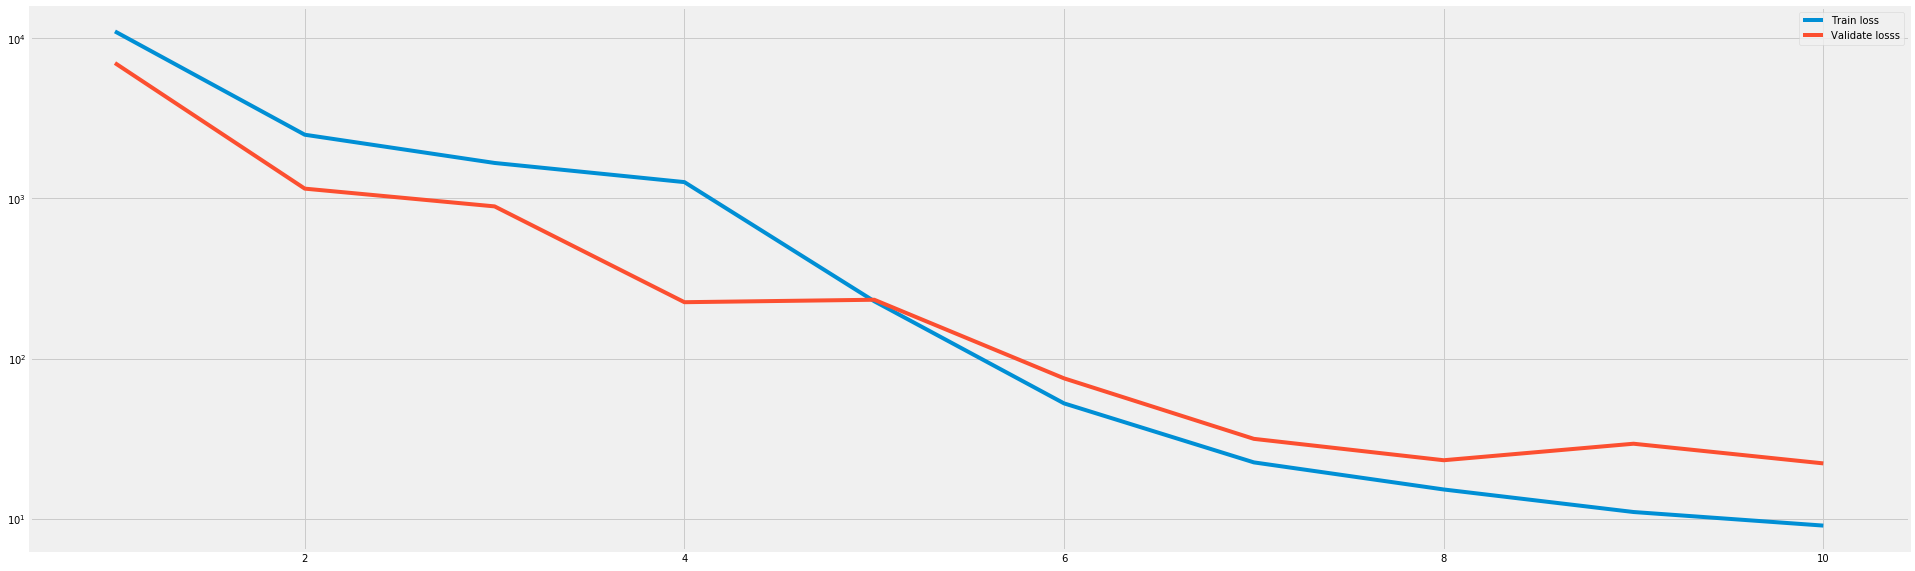

In [18]:
plt.figure(figsize = (30, 10))
plt.plot(np.arange(1, 11), hist.history['loss'])
plt.plot(np.arange(1, 11), hist.history['val_loss'])
plt.legend(['Train loss', 'Validate losss'], loc = 'upper right')
plt.yscale('log')
plt.show()

Theo biểu đồ thì ta nên dừng ở epoch thứ 6

## 3. Đánh giá model

Để công bằng ta sẽ chạy model 20 lần rồi lấy trung bình các chỉ số.

Ở đây ta có train loss, validate loss, test loss, rmse, correct direction, profit.

Giải thích:
- Rmse: Root mean square error (căn trung bình độ lỗi bình phương)
- Correct direction: Hướng (lên hoặc xuống) chính xác
- Profit: Giả định khi model báo giá lên ta mua vào 1 đồng coin (nếu giá 10\\$ thì mua 10\\$, giá 100\\$ thì mua 100\\$). Ta sẽ bán vào giá đóng của ngày hôm sau. Lời lỗ từ đó mà tính ra.

In [ ]:
indexes = {'train':[], 'val': [], 'test': [], 'rmse': [], 'correct_direction': [], 'profit': []}
iteration = 20
for i in range(iteration):
  # Model
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 3)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(20, activation=None))
  model.add(Dense(1, activation=None))
  model.compile(optimizer='adam', loss = 'mean_squared_error')
  # Fit
  hist = model.fit(X_train, y_train, batch_size=32, epochs=8, shuffle=True, validation_data=(X_val, y_val), verbose=0)
  # Lấy train loss và validate loss
  indexes['train'].append(hist.history['loss'][-1])
  indexes['val'].append(hist.history['val_loss'][-1])
  # Lấy test loss
  test_loss = model.evaluate(X_test, y_test, batch_size=32)
  indexes['test'].append(test_loss)
  # Lấy prediction để tính rmse, số lượng correct direcion và profit theo giả thuyết
  predictions = model.predict(X_test)
  predictions = predictions.reshape((1, -1))[0]
  rmse = np.sqrt(np.mean((predictions - y_test)**2))
  indexes['rmse'].append(rmse)
  correct_direction = 0
  for j in range(1, len(X_test)):
    if (predictions[j] > y_test[j - 1] and y_test[j] > y_test[j - 1]) or (predictions[j] < y_test[j - 1] and y_test[j] < y_test[j - 1]):
      correct_direction += 1
  indexes['correct_direction'].append(correct_direction/(len(X_test) - 1))
  profit = 0
  for j in range(1, len(X_test)):
    if predictions[j] > y_test[j-1]:
      profit += (y_test[j] - y_test[j-1])
  indexes['profit'].append(profit)

17/17 [==============================] - 0s 14ms/step - loss: 221.1855


In [ ]:
for value in indexes:
  print(value, sum(indexes[value])/iteration)

Sau 20 lần chạy (khoảng 40 - 50 phút), 52% hướng dự đoán đúng, trung bình lời 22$, không tệ nhưng cũng không quá tốt. Những lần in ra ở trên là kết quả loss trên tập test (522 mẫu)

Ta sẽ chạy 1 lần nữa để vẽ biểu đồ giá dự đoán

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 3)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=6, shuffle=True, validation_data=(X_val, y_val))
predictions = model.predict(X_test)
predictions = predictions.reshape((1, -1))[0]

In [ ]:
plot_df = EMA_df[['close']]
plot_df.head()

In [ ]:
# Mẫu predictions có được
predictions[:5]

In [ ]:
valid_df = plot_df.iloc[-len(predictions):]
valid_df['predictions'] = predictions
valid_df.head()

Biểu đồ giá close và giá predict

In [ ]:
# Biểu đồ tổng quan giá
plt.figure(figsize = (20, 10))
plt.plot(plot_df['close'])
plt.plot(valid_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

In [ ]:
# Biểu đồ riêng giá predict trên tập test và giá thực tế
plt.figure(figsize = (20, 10))
plt.plot(valid_df['close'])
plt.plot(valid_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

Có vẻ như model làm khá tốt việc dự đoán trend, còn về giá chính xác thì không tốt cho lắm

## 4. Kết luận:

Đầu tiên nhóm xin được trích dẫn câu nói "All models are wrong, but some are useful" nổi tiếng của giáo sư người Anh George E. P. Box - ông nổi tiếng trong lĩnh vực khoa học thống kê trong thế kỉ 20. Vậy nên cũng không nên đặt hi vọng nhiều.

Tuy đã có nhiều tiến bộ trong lĩnh vực học máy nhưng dự đoán giá cổ phiếu vẫn còn là điều ít mô hình có thể hoàn thành tốt được.

Như kết quả ở trên, bằng việc khảo sát giá và chỉ số EMA trong 60 ngày trước đó, sử dụng mô hình mạng LSTM và mạng Dense thì model hoạt động tạm chấp nhận được với rmse 9,7. Hơn nữa, nhóm đã đi sâu hơn và khảo sát tỉ lệ hướng dự đoán của mô hình cũng như có một thí nghiệm nhỏ xem độ hiệu quả của mô hình. Với 52% hướng dự đoán chính xác và hơn 500 ngày "ròng rã" mua bán thì lợi nhuận được khoảng 22$. Đây cũng coi như một thành công nho nhỏ (vì may là chưa lỗ), nhưng qua đó cũng thấy được rằng dự đoán giá cổ phiếu không phải chuyện dễ (nếu dễ thì ai cũng giàu). Nhưng đâu đó vẫn có cơ hội mở ra cho những mô hình mới cải tiến, biết đâu một ngày nào đó bằng sức mạnh máy học có thể chinh phục được điều không tưởng :) (đơn giản là nó đã làm được điều không tưởng trong vài chục năm trước).

## 5.Nguồn tham khảo:
[Stock Price Prediction Using Python & Machine Learning](https://www.youtube.com/watch?v=QIUxPv5PJOY)